# Real data

The aim of this notebook is to use PCA on the real data.

#### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from scipy.spatial import distance
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

##### Functions

In [2]:
def PCA(df, label):
    # Standardizse the features
    df_norm = (df-df.mean())/df.std()
    print('Normalized data')
    #display(df_norm)


    # Apply PCA
    pca = decomposition.PCA(n_components=4)
    PCA_df = pd.DataFrame(data = pca.fit_transform(df_norm), columns=['Component #1', 'Component #2', 'Component #3', 'Component #4'])
    print("After PCA")
    print("Singular values:", pca.singular_values_)
    #display(PCA_df)


    # Append the target Label columns
    target = pd.Series(label , name='label')

    df = pd.concat([df, target], axis = 1)
    PCA_df = pd.concat([PCA_df, target], axis = 1)
    return PCA_df, pca

In [3]:
def PCA_plot(PCA_df, comp=[0, 1], targets=['UK', 'FR']):
    x = PCA_df.iloc[:,comp[0]]
    y = PCA_df.iloc[:,comp[1]]

    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.25]
    rect_histy = [left_h, bottom, 0.25, height]

    # start with a rectangular Figure
    plt.figure(1, figsize=(12, 12))

    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)

    # the scatter plot:
    for _, idt  in enumerate(targets):
        axScatter.scatter(PCA_df[PCA_df['label'] == idt].iloc[:,comp[0]], 
                          PCA_df[PCA_df['label'] == idt].iloc[:,comp[1]])


    # now determine nice limits by hand:
    binwidth = 0.2
    xymax = np.max([np.max(np.fabs(x)), np.max(np.fabs(y))])
    lim = (int(xymax/binwidth) + 1) * binwidth

    axScatter.set_xlim((-lim, lim))
    axScatter.set_ylim((-lim, lim))

    bins = np.arange(-lim, lim + binwidth, binwidth)
    axHistx.hist(x, bins=bins)
    axHisty.hist(y, bins=bins, orientation='horizontal')

    axHistx.set_xlim(axScatter.get_xlim())
    axHisty.set_ylim(axScatter.get_ylim())

    axHistx.set_xticks([])
    axHisty.set_yticks([])

    axScatter.legend(targets)
    axScatter.grid()
    axScatter.set_xlabel('Component #'+str(comp[0]), fontsize = 15)
    axScatter.set_ylabel('Component #'+str(comp[1]), fontsize = 15)
    plt.savefig("figures/europe_data_pca" + str(comp[0]) + str(comp[1]) + ".png")
    plt.show()

##### Data Loading / merging

##### UK

In [4]:
# Data loading:
UK_covid_df = pd.read_csv("./data/UK/UK_covid.csv")
UK_covid_df['coord'] = UK_covid_df[['lat','lon']].apply(tuple, axis=1)
UK_covid_df = UK_covid_df.drop(columns= ['lat', 'lon'])
#UK_covid_df

UK_pol_df = pd.read_csv("./data/UK/UK_pol_pop.csv")
UK_pol_df['coord'] = UK_pol_df[['lat','lon']].apply(tuple, axis=1)
UK_pol_df = UK_pol_df.drop(columns= ['lat', 'lon'])
#UK_pol_df.head()

n = UK_covid_df.shape[0]
m = UK_pol_df.shape[0]
UK_covid_df['sensor_site_name'] = np.zeros(n)
UK_covid_df['distance from the sensor [km]'] = np.zeros(n)
dist_vect = np.zeros(m)
#associating a station to each UK_covid_df
for idx1, row1 in UK_covid_df.iterrows():
    pos1= np.array(row1['coord'])
    for idx2, row2 in UK_pol_df.iterrows():
        pos2 = np.array(row2['coord']) #position of the sensor
        dst = distance.euclidean(pos1, pos2)
        dist_vect[idx2] = dst
    idx_min = np.where(dist_vect == np.amin(dist_vect))[0][0]
    UK_covid_df.loc[idx1, 'sensor_site_name'] = UK_pol_df.loc[idx_min,'site']
    p = row1['coord'] #sensor's position
    s = UK_pol_df.loc[idx_min, 'coord'] #associated sensor position
    UK_covid_df.loc[idx1, 'distance from the sensor [km]'] = geodesic(p, s).km
    
threshold = 20
UK_covid_df = UK_covid_df[UK_covid_df['distance from the sensor [km]'] < threshold]
UK_covid_dff = UK_covid_df.groupby(['sensor_site_name'], as_index=False).agg({'# death':  np.sum})

#finally merge the two datasets
UK_merged = UK_covid_dff.merge(UK_pol_df, left_on='sensor_site_name', right_on='site')
UK_merged = UK_merged[['# death', 'no2', 'pm10', 'pm2.5', 'population']]
UK_merged['death_ratio'] = UK_merged['# death']/UK_merged['population']
UK_merged = UK_merged.drop(columns=['# death','population'])
UK_merged.head()

,no2,pm10,pm2.5,death_ratio
0,31.486575,18.136199,12.977897,0.000807
1,27.290171,17.094891,12.165736,0.000447
2,64.735355,23.568150,18.968763,0.000215
3,24.618499,17.752360,11.066149,0.001736
4,25.497863,16.736710,10.123403,0.000219


#### France

In [5]:
FR_pol_df = pd.read_csv("./data/France/FR_pol.csv", dtype={'# dept': object})
FR_covid_df = pd.read_csv("./data/France/FR_covid.csv")[['No', 'Département', 'Décès > 03/06']]
FR_merged = pd.merge(FR_pol_df, FR_covid_df, left_on='# dept', right_on='No')
FR_merged = FR_merged[['Décès > 03/06','NO2','PM10','PM2.5', 'population']]
FR_merged.columns = ['# death', 'no2', 'pm10', 'pm2.5', 'population']
FR_merged['death_ratio'] = FR_merged['# death']/FR_merged['population']
FR_merged = FR_merged.drop(columns=['# death','population'])
FR_merged.head() # TODO we are missing # death here from the official number :S the source is not good enough? But let us neglect that right now to continue

,no2,pm10,pm2.5,death_ratio
0,19.266667,19.000000,14.000000,0.000432
1,36.015873,22.285714,14.636364,0.000566
2,36.666364,22.393617,12.245455,0.000263
3,8.600000,10.250000,7.500000,0.000062
4,11.812500,16.775000,11.416667,0.000252


##### PCA results

In [6]:
# Final merge
All_df = UK_merged.append(FR_merged, ignore_index=True)
label = np.hstack((["UK"]*len(UK_merged), ["FR"]*len(FR_merged)))

# Compute IRQ
Q1=All_df.quantile(0.25)
Q3=All_df.quantile(0.75)
IQR=Q3-Q1
lowqe_bound=Q1 - 1.5 * IQR
upper_bound=Q3 + 1.5 * IQR

# Filter the outliers
label  = label[~((All_df < lowqe_bound) |(All_df > upper_bound)).any(axis=1)]
All_df = All_df[~((All_df < lowqe_bound) |(All_df > upper_bound)).any(axis=1)]

# Apply PCA
PCA_df, pca = PCA(All_df, label)
PCA_df

Normalized data
After PCA
Singular values: [9.82809116 7.09382197 6.24462426 5.48552476]


,Component #1,Component #2,Component #3,Component #4,label
0,-0.905764,0.432847,0.406162,-0.677990,UK
1,0.127876,-0.050678,0.458451,-0.487655,UK
2,-0.360312,2.755415,-0.068949,-0.051172,UK
3,1.115397,-0.046687,1.137957,0.091943,UK
4,-1.294106,-1.288138,-0.297144,0.397519,UK
5,-0.704971,-0.877207,1.591609,-0.565967,UK
6,0.796910,-0.424771,-0.386220,0.071609,UK
7,3.428723,0.387343,0.372235,0.285948,UK
8,0.243538,-1.280540,-1.432759,0.970460,UK
9,2.798199,0.538287,1.345581,-0.405834,UK


##### Plots

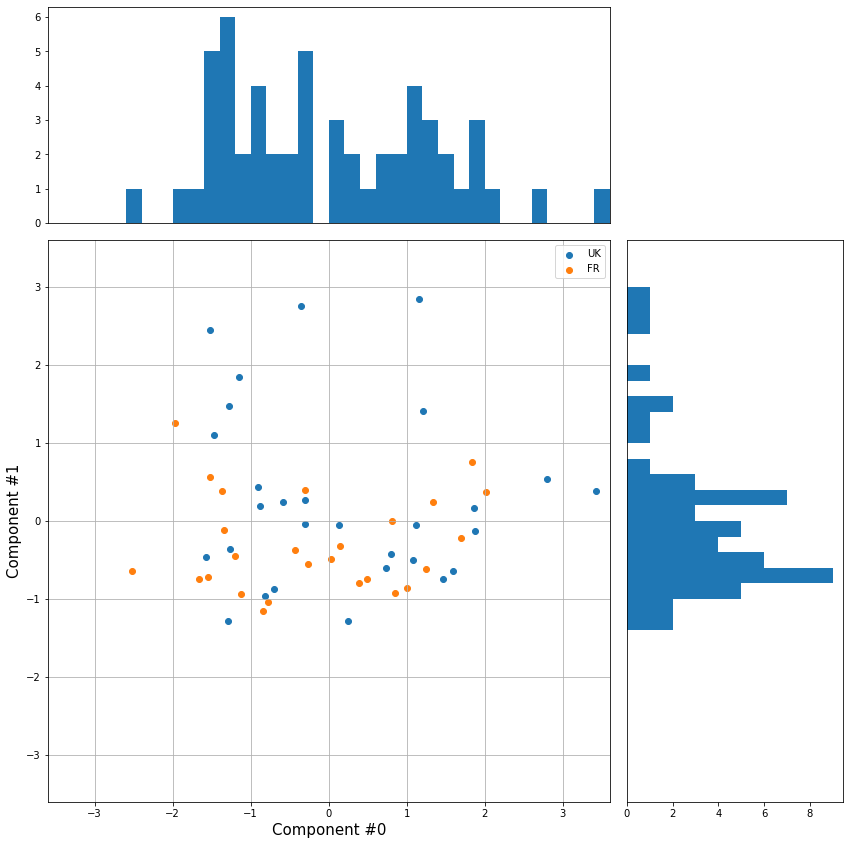

In [7]:
PCA_plot(PCA_df)

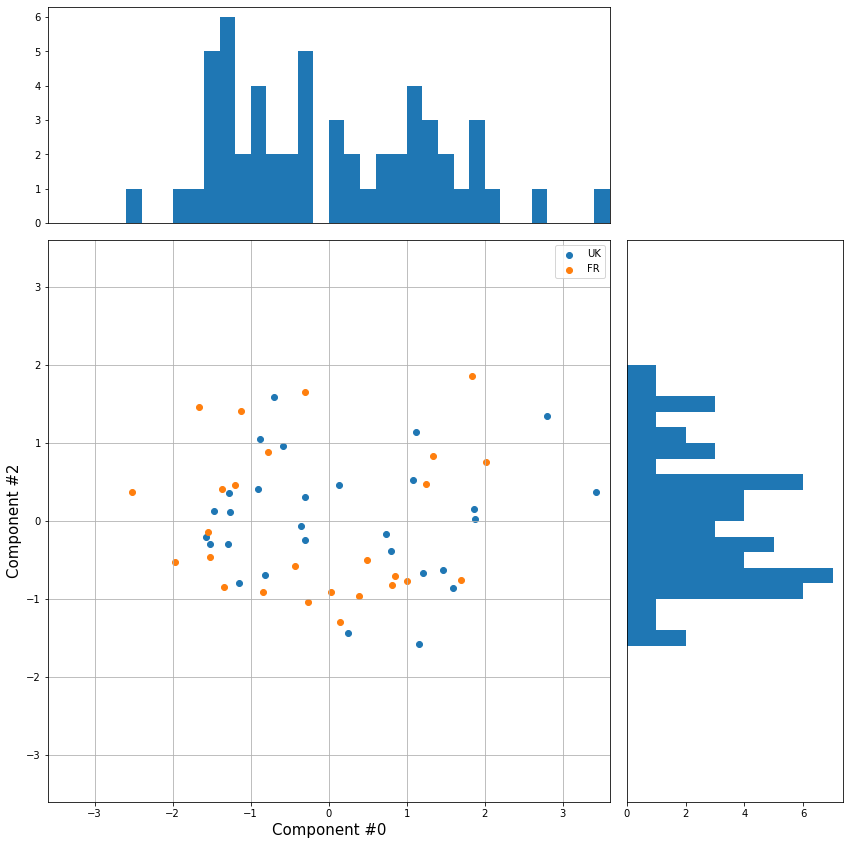

In [8]:
PCA_plot(PCA_df, [0, 2])

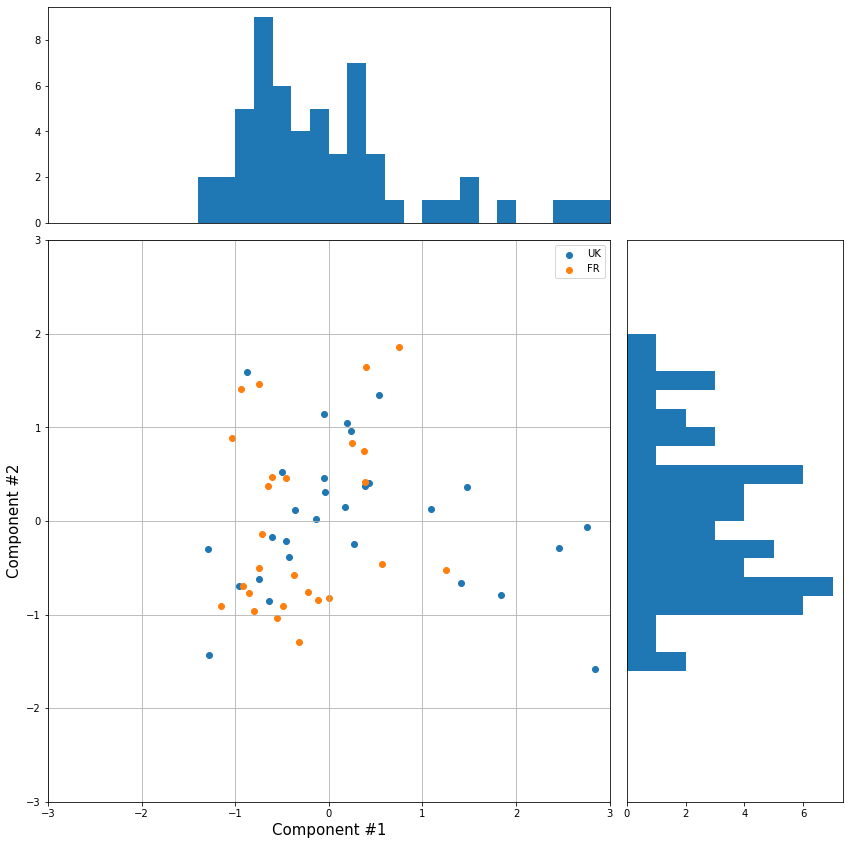

In [9]:
PCA_plot(PCA_df, [1, 2])

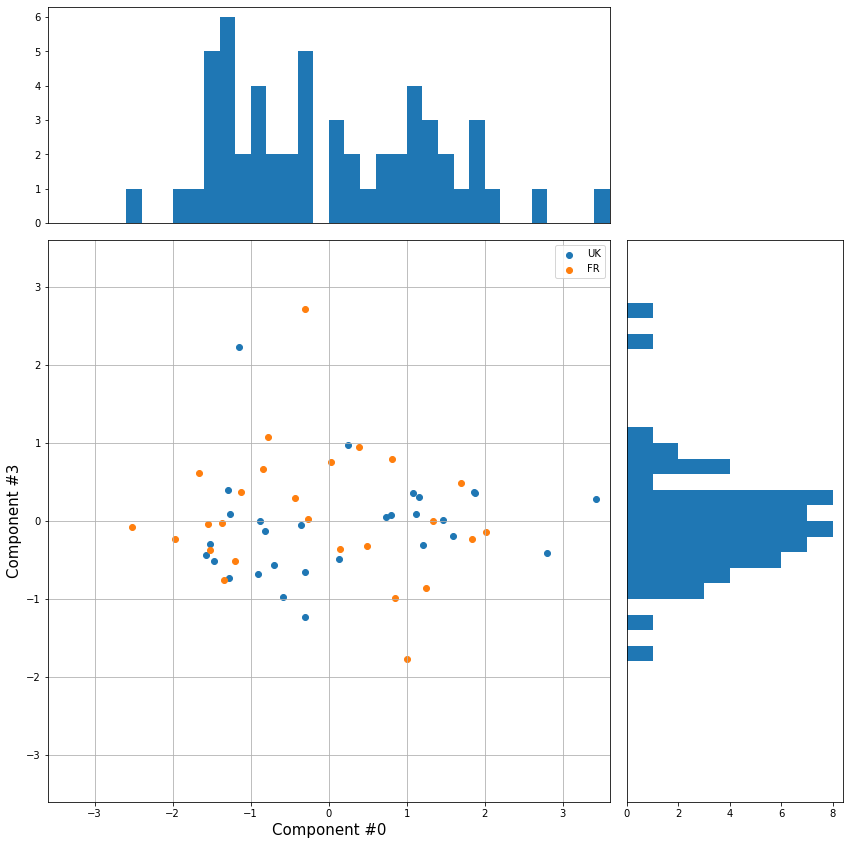

In [10]:
PCA_plot(PCA_df, [0, 3])

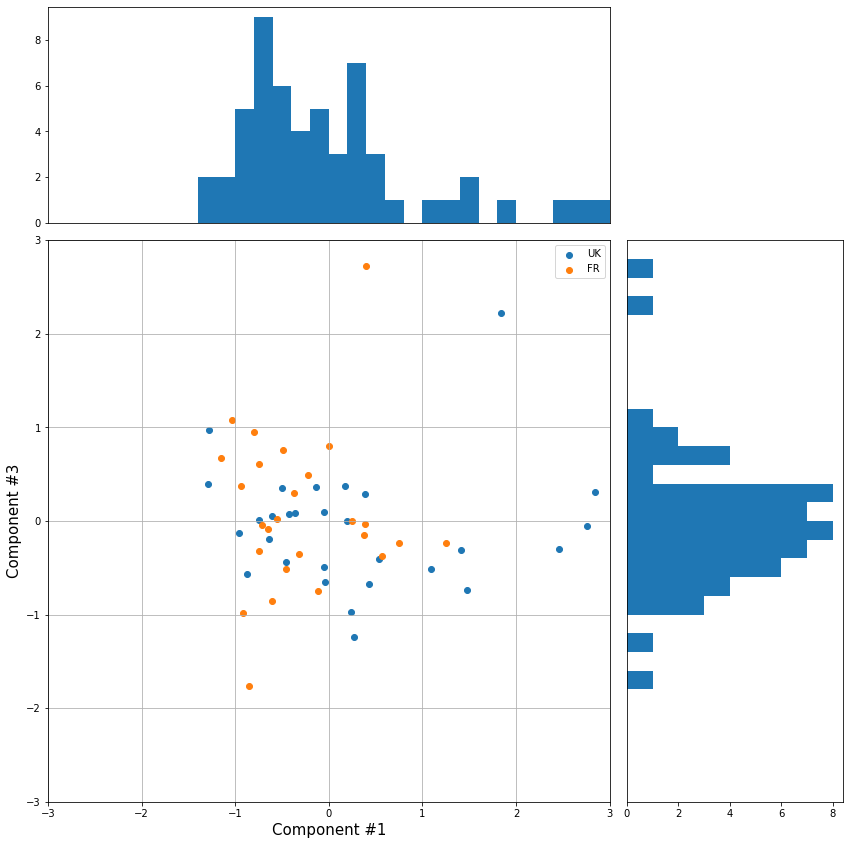

In [11]:
PCA_plot(PCA_df, [1, 3])

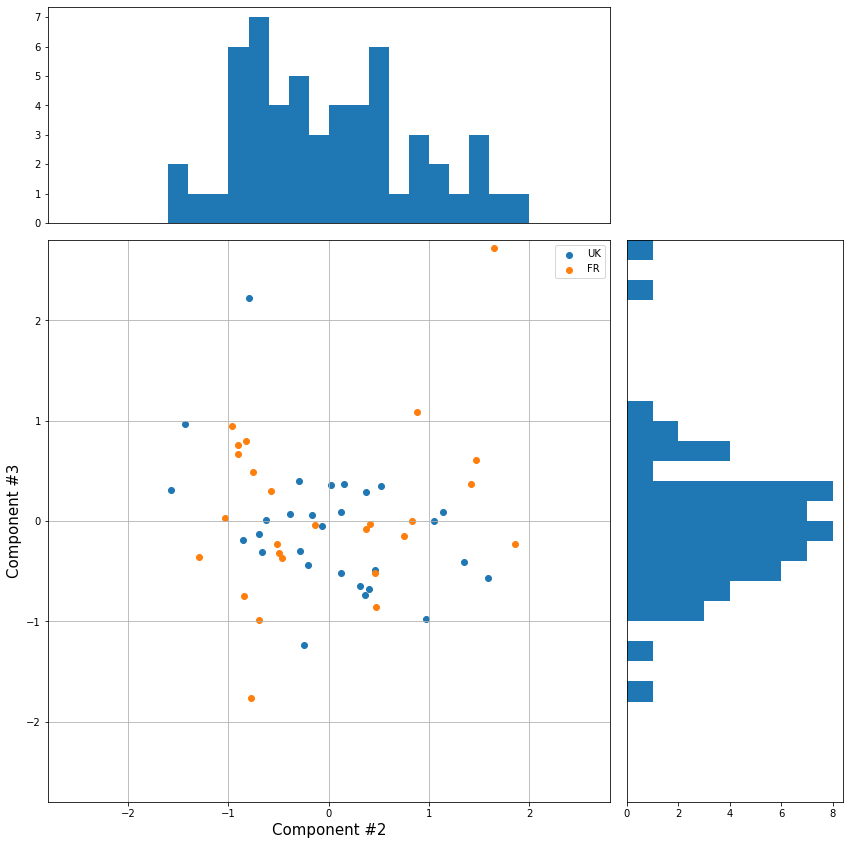

In [12]:
PCA_plot(PCA_df, [2, 3])

In [13]:
def plot_pca_3d(c1, c2, c3):  
    fig = plt.figure(figsize = (8,8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=30, azim=30)
    df = PCA_df
    targets = ['UK', 'FR']

    for _, idt in enumerate(targets):
        ax.scatter(df[df['label'] == idt].iloc[:,c1], 
                   df[df['label'] == idt].iloc[:,c2],
                   df[df['label'] == idt].iloc[:,c3])

    ax.legend(targets)
    ax.grid()
    ax.set_xlabel('Component #' + str(c1), fontsize = 15)
    ax.set_ylabel('Component #' + str(c2), fontsize = 15)
    ax.set_zlabel('Component #' + str(c3), fontsize = 15)
    ax.set_title('PCA', fontsize = 20)
    plt.savefig("figures/europe_data_pca3d" + str(c1) + str(c2) + str(c3) + ".png")
    plt.show()

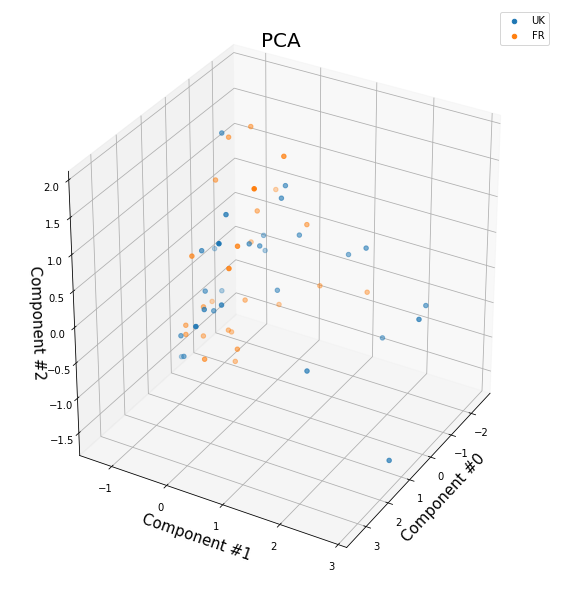

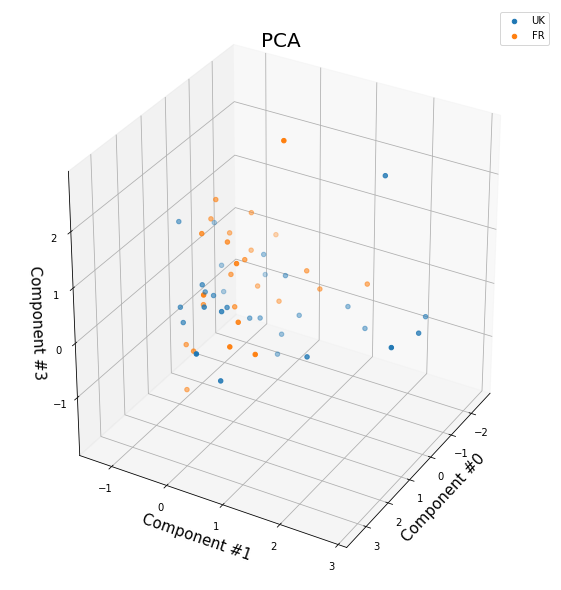

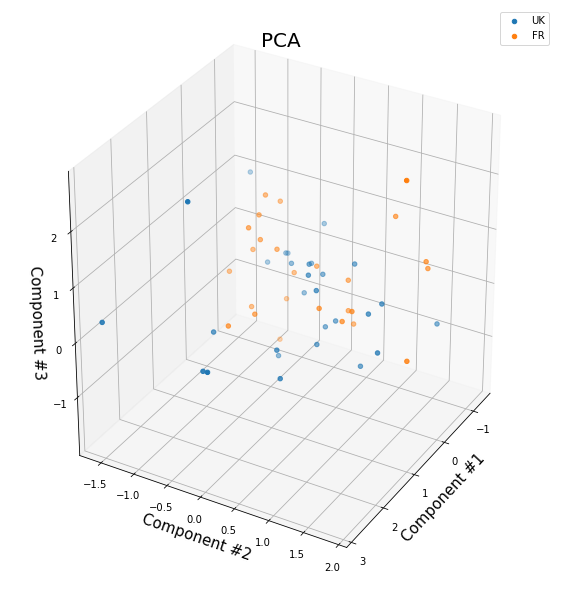

In [14]:
plot_pca_3d(0,1,2)
plot_pca_3d(0,1,3)
plot_pca_3d(1,2,3)

#### Correlation circle

In [15]:
#plot function
def plot_corr_circle(c1, c2):
    # Plot 0 vs 1
    fig, ax = plt.subplots(figsize=(10,10))
    plt.xlim(-1.25,1.25)
    plt.ylim(-1.25,1.25)

    circle1 = plt.Circle((0, 0), 1, color='k', linestyle='--', fill=False)
    ax.add_artist(circle1)

    for c in All_df:
        ax.annotate(c, xy=(circle_df[c][c1]/2, circle_df[c][c2]/2))
        ax.add_artist(plt.arrow(0, 0, circle_df[c][c1], circle_df[c][c2], head_width=0.05, length_includes_head=True))

    ax.set_aspect(1)
    plt.grid(linestyle='--')
    plt.xlabel('Component #' + str(c1))
    plt.ylabel('Component #' + str(c2))
    plt.savefig('figures/europe_data_corr_circle' + str(c1) + str(c2) + ".png")
    plt.show()


,no2,pm10,pm2.5,death_ratio
0,-0.533268,-0.594647,-0.516879,-0.307988
1,-0.021674,-0.139377,-0.365517,0.920055
2,0.748487,-0.011355,-0.621512,-0.231000
3,-0.393602,0.791732,-0.461472,-0.072667


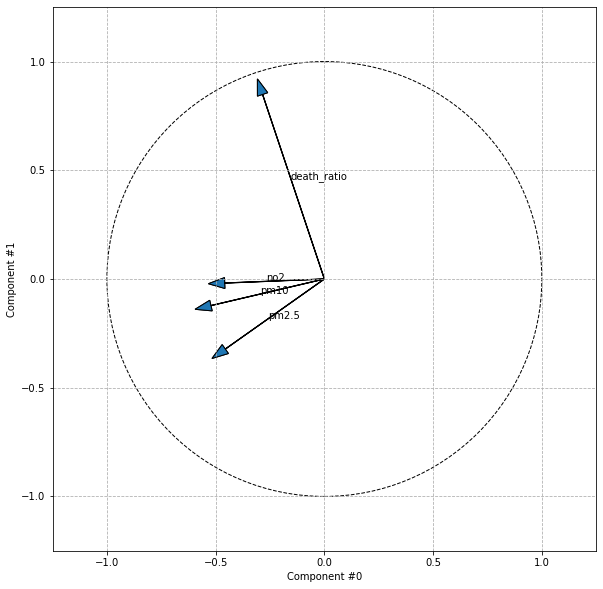

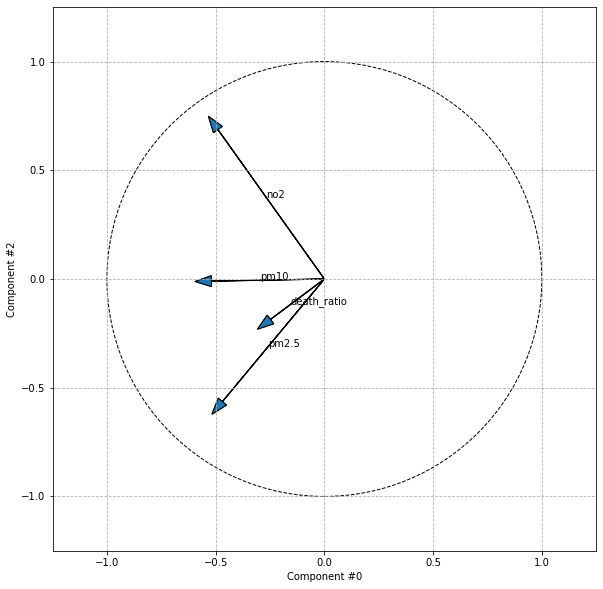

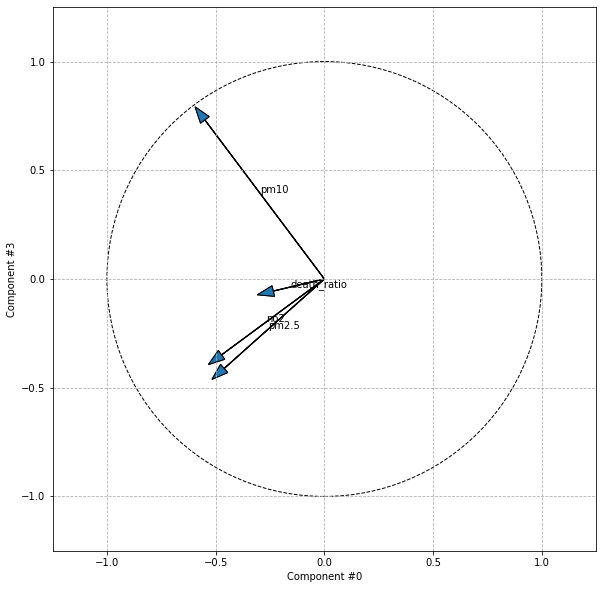

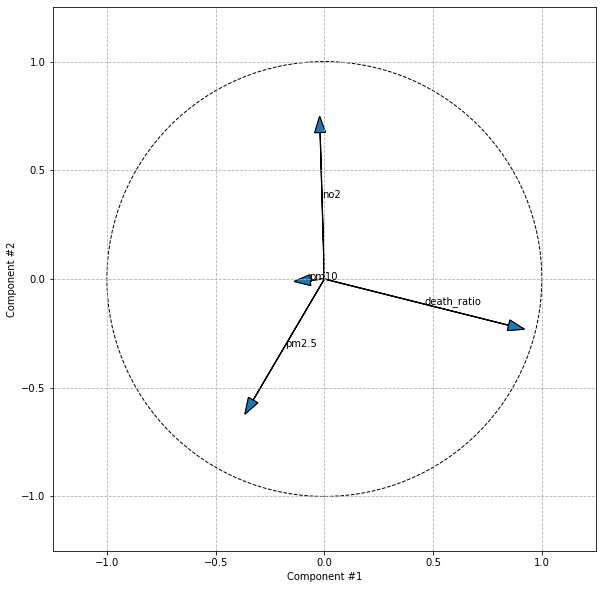

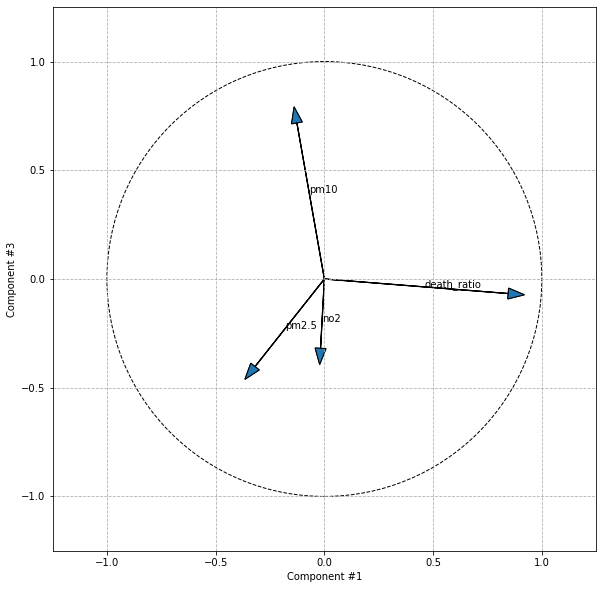

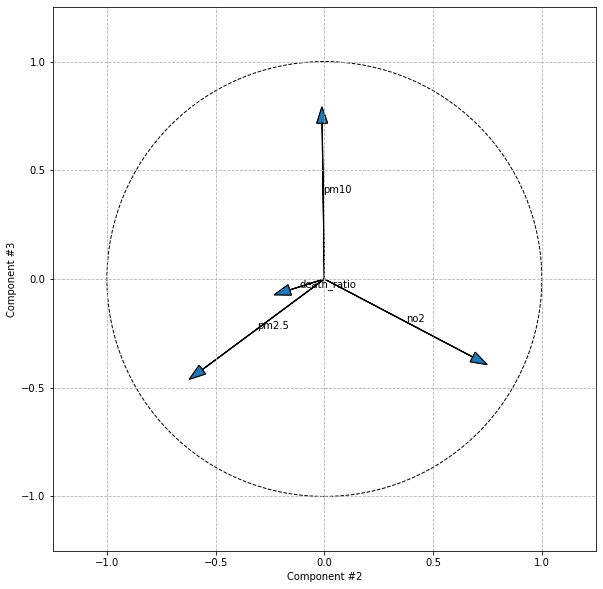

In [16]:
circle_df = pd.DataFrame(data=[[pca.components_[c,n] for n in range(pca.n_components_)] for c in range(pca.n_components_)], index=[0,1,2,3], columns = All_df.columns)
display(circle_df)


# Plot 0 vs 1
plot_corr_circle(0, 1)

# Plot 0 vs 2
plot_corr_circle(0, 2)

# Plot 0 vs 3
plot_corr_circle(0, 3)

# Plot 1 vs 2
plot_corr_circle(1, 2)

# Plot 1 vs 3
plot_corr_circle(1, 3)

# Plot 2 vs 3
plot_corr_circle(2, 3)
